In [2]:
import numpy as np
import cvxpy as cp
import pandas as pd
import mosek
import matplotlib.pyplot as plt
import Hit_and_Run as hr
import phi_divergence as phi
from scipy.optimize import fsolve
import scipy.stats as stats 

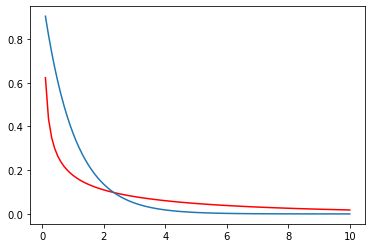

In [63]:

#define x-axis values
x = np.linspace (0.1, 10, 100) 
def weibull_pdf(x,k,lbda):
    a = k/lbda
    b = x/lbda
    return(a*b**(k-1)*np.exp(-b**k))

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=0.5, scale=8)
z = weibull_pdf(x,1.001,1)



#create plot of Gamma distribution
plt.plot(x, y,color = 'red')
plt.plot(x,z)


In [65]:
def poly_cvar_port_pos(p,alpha,R,f,l):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(n)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [cp.sum(a)==1, a>=0, 1-s/l*(1-p) <= z]
    X = R @ a
    som = 0
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-X[i])) <= s[i])
        arg = cp.pos(1+s[i]/l*(p-1))
        constraints.append(l*(1/p*(arg)**(p/(p-1))-1/p) <= t[i])
    obj = cp.Maximize(theta_1+theta_2-f@t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, a.value)

def poly_cvar_port_ball(p,alpha,R,f,r):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    lbda = cp.Variable(1, nonneg = True)
    t = cp.Variable(n)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    X = R @ a
    constraints = [lbda-s*(1-p) <= z]
    macht = np.array([(p-1)/p, 1-(p-1)/p])
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-X[i])) <= s[i])
        constraints.append(z[i] <= cp.geo_mean(cp.vstack([lbda+p*t[i],lbda]),macht))
    obj = cp.Minimize(-theta_1-theta_2+lbda*r+t@f)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, a.value)


def cvar_port(alpha,R,f):
    n = len(R)
    I = len(R[0])
    a = cp.Variable(I)
    eta = cp.Variable(1)
    som = 0
    constraints = [cp.sum(a)==1, a>= 0]
    X = R @ a
    for i in range(n):
        som = som - f[i]*cp.pos(-1/alpha * (X[i]-eta))
    obj = cp.Maximize(eta + som)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, a.value)

def poly_cvar(p,alpha,x,f,l):
    n = len(x)
    theta_1 = cp.Variable(1)
    theta_2 = cp.Variable(1)
    t = cp.Variable(1)
    z = cp.Variable(n, nonneg= True)
    s = cp.Variable(n)
    constraints = [1-s/l*(1-p) <= z]
    som = 0
    for i in range(n):
        constraints.append(theta_1 + cp.pos(1/alpha*(theta_2-x[i])) <= s[i])
        som = som + l*f[i]*(1/p*(z[i]**(p/(p-1)))-1/p)
    constraints.append(som <= t)
    obj = cp.Maximize(theta_1+theta_2-t)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver = cp.MOSEK)
    return(prob.value, theta_1.value, theta_2.value)



In [66]:
def partial_pcvar(theta, p, x, alpha):
    arg = 1 + (theta[0]-np.min([1/alpha * (x-theta[1]),0]))*(p-1)
    par1 = np.max([arg,0])**(1/(p-1))
    par2 = 0
    if x <= theta[1]:
        par2 = np.max([arg,0])**(1/(p-1))*(1/alpha)
    return(par1, par2)

def d_pcvar_pos(theta, *data):
    p,X,alpha = data
    n = len(X)
    partial_1 = 0
    partial_2 = 0
    #print(theta)
    for i in range(n):
        par1, par2 = partial_pcvar(theta, p, X[i], alpha)
        #print(par1,par2)
        partial_1 = partial_1 + par1
        partial_2 = partial_2 + par2
    return(1/n*partial_1-1, 1/n*partial_2-1)

def wc_pcvar2(root,*data):
    p,X,alpha = data
    n = len(X)
    wc = 0
    for i in range(n):
        arg_1 = root[0] + 1/alpha * np.maximum(root[1]-X[i],0)
        wc = wc - 1/n * poly_conj(p,arg_1)
    return(wc + np.sum(root))

def poly(p,x):
    return((x**p-p*(x-1)-1)/(p*(p-1)))

def poly_conj(p,x):
    return(1/p*np.max([1+x*(p-1),0])**(p/(p-1))-1/p)

In [67]:
def cvar_fast(alpha,x,f):
    n = len(f)
    order = np.argsort(x)
    x = np.sort(x)
    f = f[order]
    csum = np.cumsum(f)
    if csum[0] > alpha:
        return(x[0])
    else:
        k_max = np.max(np.where((csum < alpha)==True))
    Ex = np.sum(np.multiply(x[0:k_max+1],f[0:k_max+1]))
    last = (alpha - csum[k_max])*x[k_max+1]
    return(1/alpha*(Ex+last))

In [33]:
np.random.seed(13)
n = 1000
f = np.zeros(n)+1/n
mean = np.array([-0.1,-1.5])
sigma = np.array([[1,-0.25],[-0.25,1]])
R = np.random.multivariate_normal(mean, sigma,size = n)
alpha=0.05
l=1
p = 2
nom_sol = cvar_port(alpha,R,f)
rob_sol = poly_cvar_port_pos(p,alpha,R,f,l)
print(nom_sol)
print(rob_sol)

(-1.9224499930385968, array([0.65521222, 0.34478778]))
(-2.2833950490976807, array([0.60538482, 0.39461518]))


In [185]:
R = np.random.multivariate_normal(mean, sigma,size = n)
port = R.dot(nom_sol[1])
cvar_fast(alpha,port,f)

-1.6883045480393672

In [186]:
R2 = np.random.multivariate_normal(mean, sigma,size = n)
port = R2.dot(nom_sol[1])
data = (p,port,alpha)
theta_0 = np.array([-0.072,-1.287])
root = fsolve(d_pcvar_pos, theta_0, args = data)
print(root)
print(d_pcvar_pos(root, *data))
print(wc_pcvar2(root,*data))
#print(poly_cvar(p,alpha,port,f,l))

[-0.07352941 -1.82937887]
(-2.6645352591003757e-14, 0.0)
-2.054457178651252


In [187]:
port_rob = R2.dot(rob_sol[1])
data2 = (p,port_rob,alpha)
theta_0 = np.array([-0.069203,-1.32391])
root = fsolve(d_pcvar_pos, theta_0, args = data2)
print(root)
print(d_pcvar_pos(root, *data2))
print(wc_pcvar2(root,*data2))
#print(poly_cvar(p,alpha,port_rob,f,l))

[-0.07243816 -1.82975838]
(7.105427357601002e-15, 8.881784197001252e-15)
-2.0477416570571783


In [110]:
np.random.seed(13)
n = 8000
f = np.zeros(n)+1/n
mean = np.array([-0.1,-1.5])
sigma = np.array([[1,-0.25],[-0.25,1]])
R = np.random.multivariate_normal(mean, sigma,size = n)
w = np.arange(0,1.1,0.03)
cvar_nom = []
wc_cvar = []
index = []
alpha=0.05
l=1
p = 2
for i in range(len(w)):
    port = R.dot(np.array([w[i],1-w[i]]))
    data2 = (p,port,alpha)
    theta_0 = np.array([-0.069203,-1.32391])
    root = fsolve(d_pcvar_pos, theta_0, args = data2)
    root_value = d_pcvar_pos(root, *data2) 
    if np.max(root_value) <= 1e-5:
        print(i)
        index.append(i)
        wc_cvar.append(wc_pcvar2(root,*data2))
        cvar_nom.append(cvar_fast(alpha, port, f))

0
1
3
4
5
7
8
10
11
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
28
29
30
32
33
34
35
36


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


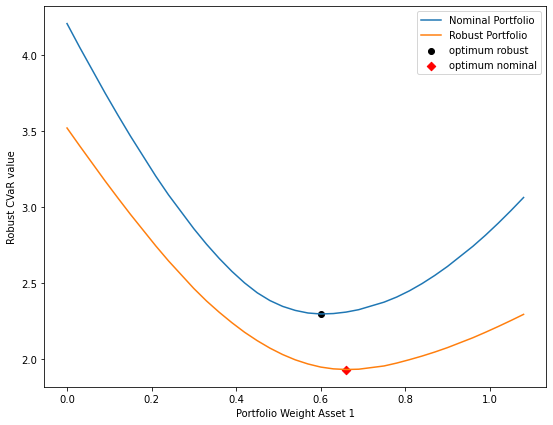

In [111]:
plt.figure(figsize=(9, 7))
plt.plot(w[index],-np.array(wc_cvar), label = 'Nominal Portfolio')
plt.plot(w[index],-np.array(cvar_nom), label = 'Robust Portfolio')
plt.scatter(w[index[np.argmax(wc_cvar)]], -np.max(wc_cvar), color = 'black', label = 'optimum robust')
plt.scatter(w[index[np.argmax(cvar_nom)]], -np.max(cvar_nom),marker = "D", color = 'red', label = 'optimum nominal' )
plt.legend()
plt.xlabel('Portfolio Weight Asset 1')
plt.ylabel('Robust CVaR value')
plt.savefig('RobustCVaRPortfolio.eps', format = 'eps')

In [128]:
mu_1 = -0.1 + np.random.normal(0,0.032*2,size = 10)
mu_2 = -1.5 + np.random.normal(0,0.032*2,size = 10)
wc_risk = np.zeros(len(mu_1))
wc_portfolio = np.zeros(len(mu_1))
alpha=0.05
l=1
p = 2
for i in range(len(mu_1)):
    print(i)
    n = 2000
    f = np.zeros(n)+1/n
    mean = np.array([mu_1[i],mu_2[i]])
    sigma = np.array([[1,-0.25],[-0.25,1]])
    R = np.random.multivariate_normal(mean, sigma,size = n)
    rob_res = poly_cvar_port_pos(p,alpha,R,f,l)
    wc_risk[i] = rob_res[0]
    wc_portfolio[i] = rob_res[1][0]

0
1
2
3
4
5
6
7
8
9


In [15]:
mu_1 = -0.1 + np.random.normal(0,0.032*2,size = 300)
mu_2 = -1.5 + np.random.normal(0,0.032*2,size = 300)
wc_risk = []
alpha=0.05
l=1
p = 2
n = 5000
mean = np.array([-0.1, -1.5])
sigma = np.array([[1,-0.25],[-0.25,1]])
f = np.zeros(n)+1/n
R = np.random.multivariate_normal(mean, sigma,size = n)
rob_res = poly_cvar_port_pos(p,alpha,R,f,l)
for i in range(len(mu_1)):
    mean = np.array([mu_1[i],mu_2[i]])
    sigma = np.array([[1,-0.25],[-0.25,1]])
    R = np.random.multivariate_normal(mean, sigma,size = n)
    port = R.dot(rob_res[1])
    data2 = (p,port,alpha)
    theta_0 = np.array([-0.069203,-1.32391])
    root = fsolve(d_pcvar_pos, theta_0, args = data2)
    root_value = d_pcvar_pos(root, *data2) 
    if np.max(root_value) <= 1e-5:
        print(i)
        wc_risk.append(wc_pcvar2(root,*data2))

1
2
4
5
6
7
8
9
10
11
12
13
14
16
18
19
20
21
22
23
24
25
26
28
29
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49


C:\Users\gjin\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


51
52
54
55
56
57
58
59
60
62
63
64
65
66
67
68
70
71
72
73
74
75
76
77
78
79
81
82
83
84
85
86
88
91
96
97
98
99
100
101
104
105
106
108
109
111
112
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
148
149
150
151
152
154
155
156
157
158
159
160
162
163
164
165
166
168
170
171
172
173
174
175
176
177
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
221
222
223
225
226
227
228
229
230
231
232
234
236
239
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
259
260
261
262
263
264
265
266
268
269
270
272
273
275
276
277
279
280
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299


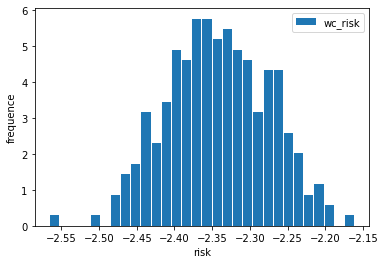

In [29]:
dt1 = pd.DataFrame(data = {'wc_risk': wc_risk})
plt.hist(dt1, density = True, bins = 30, rwidth=0.9)
plt.xlabel('risk')
plt.ylabel('frequence')
plt.legend(dt1.columns)

In [8]:
rob_res[0]

-2.346846958659985